In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error as mse, f1_score, confusion_matrix,classification_report
from sklearn.metrics import fbeta_score,make_scorer
import scipy
from scipy.stats import chi2_contingency


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn
from imblearn.metrics import geometric_mean_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost

## Feature Selection and engineering

In [12]:
df=pd.read_csv("Custmer Booking clean data.csv")
df.head()

,Unnamed: 0,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0
4,8,1,Internet,RoundTrip,80,22,4,1,AKLDEL,New Zealand,0,0,1,5.52,0


### Route VS Flight Duration:
    

In [ ]:
plt.figure(figsize=(24,8))
sns.barplot(df,x=df["route"],y=df["flight_duration"])

In [14]:
new_df=pd.get_dummies(df)
new_df.drop(columns=["Unnamed: 0"],inplace=True)

In [15]:
new_df["booking_complete"]

0        0
1        0
2        0
3        0
4        0
        ..
31903    0
31904    0
31905    0
31906    0
31907    0
Name: booking_complete, Length: 31908, dtype: int64

In [16]:
new_df.duplicated().sum()

0

##### p-value is close to 0, so route and booking origin are correlated with booking_complete .

### Encoding Categorical Data 

In [ ]:
encoder=OneHotEncoder()
encoder.fit_transform(df)

In [18]:
new_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,6,1,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,48,20,4,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
4,1,80,22,4,1,0,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,2,27,6,9,6,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0
31904,1,111,6,4,7,0,0,0,5.62,0,...,0,0,0,0,0,0,0,0,0,0
31905,1,24,6,22,6,0,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0
31906,1,15,6,11,1,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X=new_df.drop(columns=["booking_complete"])
Y=new_df["booking_complete"]

In [20]:
for col in X.columns:
    if len(X[col].unique())==2:
        if (1 in X[col].unique()) and (0 in X[col].unique()):
            X[col]=X[col].astype("int")
       


# Train Models with all features:

In [21]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=15,stratify=Y)
print("x_train: ",x_train.shape,"y_train: ",y_train.shape,
      "x_test: ",x_test.shape,"y_test: ",y_test.shape)

x_train:  (22335, 883) y_train:  (22335,) x_test:  (9573, 883) y_test:  (9573,)


In [22]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
smote
x_sm,y_sm=smote.fit_resample(x_train,y_train)
y_sm.value_counts()
x_sm.shape


x_sm.duplicated().sum()

1068

In [23]:
sm_df=pd.concat([x_sm,pd.DataFrame(y_sm)],axis=1)
sm_df.drop_duplicates(inplace=True)

In [24]:
x_sm_train=sm_df.drop(columns=["booking_complete"])
y_sm_train=sm_df["booking_complete"]

In [25]:
xgb=xgboost.XGBClassifier(enable_categorical=True,tree_method="hist")
rnf=RandomForestClassifier()
tree=DecisionTreeClassifier()
supvec=svm.SVC()
lr=LogisticRegression()
knn=KNeighborsClassifier()
models={"xgboost":xgb,"RandomForest":rnf,"DecisionTree":tree,"Support Vector Machine":supvec,
        "LogisticRegression":lr,"KNeighbors":knn}
list(models.keys())[1]

'RandomForest'

In [43]:
scores=[]
def model_train_eval(model):
    # fit the model:
    model.fit(x_sm_train,y_sm_train)
    #print training score:
    #print("training score: ",f1_score(x_train,y_train))
    
    #calculate prediction:
    predictions=model.predict(x_test)
    
    #calculate the F1 score:
    score=f1_score(predictions,y_test)
    scores.append(score)
    print("f1_score = ",score)
    
    #print the confusion matrix:
    matrix=confusion_matrix(predictions,y_test)
    print("confusion matrix: ", matrix)
    sns.heatmap(matrix,annot=True)
    
    print("classification report: ")
    print(classification_report(predictions,y_test))
    
    
    
    

f1_score =  0.3375438596491228
confusion matrix:  [[7204 1044]
 [ 844  481]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      8248
           1       0.32      0.36      0.34      1325

    accuracy                           0.80      9573
   macro avg       0.61      0.62      0.61      9573
weighted avg       0.81      0.80      0.81      9573



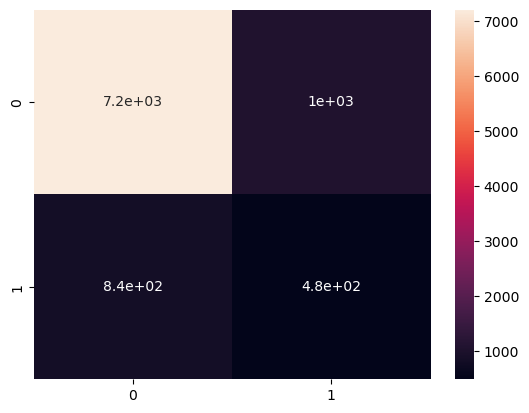

In [20]:
model_train_eval(xgb)

f1_score =  0.3034811068134484
confusion matrix:  [[6722 1015]
 [1326  510]]
classification report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7737
           1       0.33      0.28      0.30      1836

    accuracy                           0.76      9573
   macro avg       0.58      0.57      0.58      9573
weighted avg       0.74      0.76      0.75      9573



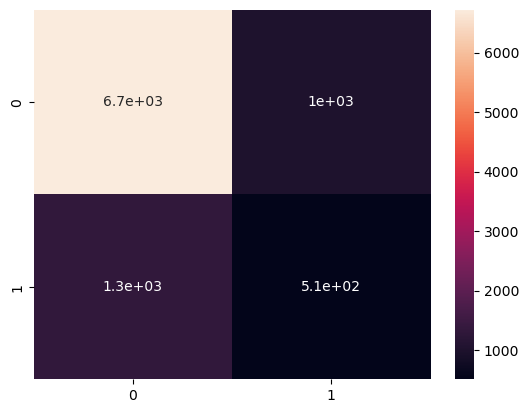

In [21]:
model_train_eval(tree)

In [22]:
model_train_eval(supvec)

KeyboardInterrupt: 

f1_score =  0.31362467866323906
confusion matrix:  [[7277 1098]
 [ 771  427]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8375
           1       0.28      0.36      0.31      1198

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.83      0.80      0.81      9573



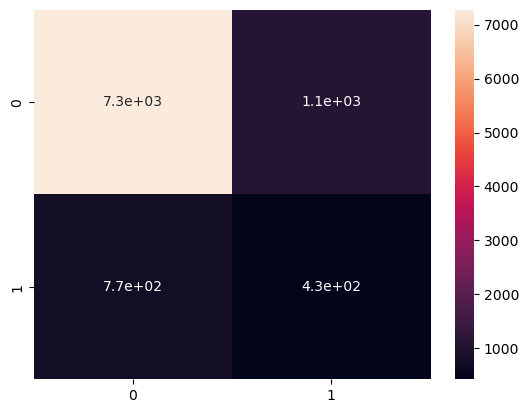

In [23]:
model_train_eval(rnf)

C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_score =  0.30143400643839624
confusion matrix:  [[6671 1010]
 [1377  515]]
classification report: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      7681
           1       0.34      0.27      0.30      1892

    accuracy                           0.75      9573
   macro avg       0.58      0.57      0.57      9573
weighted avg       0.73      0.75      0.74      9573



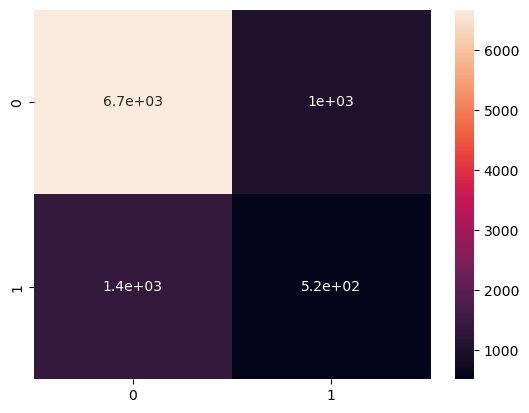

In [24]:
model_train_eval(lr)

In [22]:
# open this link
"https://scikit-learn.org/stable/supervised_learning.html"

'https://scikit-learn.org/stable/supervised_learning.html'

## Cross Validation


In [26]:
# evaluate a model with repeated stratified k fold cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_validate(rnf, x_sm_train, y_sm_train,
                        scoring="accuracy", cv=cv, n_jobs=-1,return_estimator=True)
print(scores)




{'fit_time': array([41.78414655, 41.59166145, 41.48546624, 41.30243731, 39.97780895,
       40.02899432, 40.03895903, 40.00844288, 41.31146121, 41.15868402,
       41.21871281, 41.32678151, 43.03320956, 42.5477035 , 42.06301188,
       41.86378527, 42.84507251, 42.78564572, 42.4031949 , 42.47465849,
       42.8496201 , 43.04769206, 42.78553939, 42.88823056, 42.52727318,
       42.97982478, 42.74845386, 43.25055861, 29.70958734, 29.04344606]), 'score_time': array([0.42286992, 0.3879621 , 0.37400055, 0.35804081, 0.35415912,
       0.41324306, 0.41331768, 0.44498134, 0.34231663, 0.42167115,
       0.46436334, 0.55697227, 0.37217927, 0.39259005, 0.4154222 ,
       0.52439833, 0.36419225, 0.42108035, 0.39145327, 0.52290511,
       0.38247848, 0.48396111, 0.54184866, 0.47419691, 0.37235308,
       0.41085553, 0.39309978, 0.41369891, 0.26169157, 0.23895502]), 'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClass

Model score:  88.43274297893038
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      8329
           1       0.29      0.35      0.31      1244

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



Text(0.5, 1.0, 'Classification matrix')

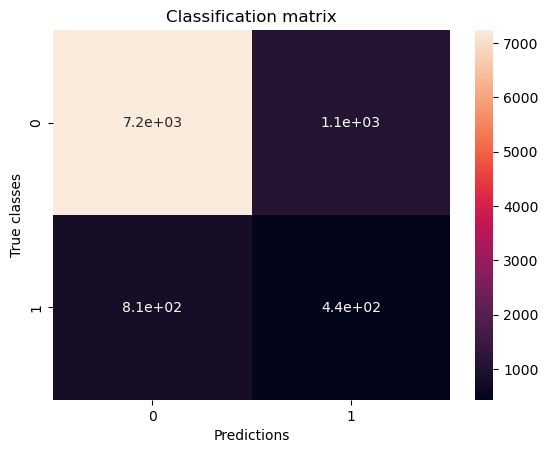

In [51]:
print("Model score: ",scores["test_score"].mean()*100)
predictions=scores["estimator"][0].predict(x_test)

matrix=confusion_matrix(predictions,y_test)
print("Classification report: ")
print(classification_report(predictions,y_test))
sns.heatmap(matrix,annot=True)
plt.xlabel("Predictions")
plt.ylabel("True classes")
plt.title("Classification matrix")

In [28]:
scores["estimator"][0]

RandomForestClassifier()

In [47]:
global_importances = pd.Series(scores["estimator"][0].feature_importances_, index=x_sm_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
Top20Featurs=global_importances.tail(20)

Text(0.5, 1.0, 'Top 20 Important Features')

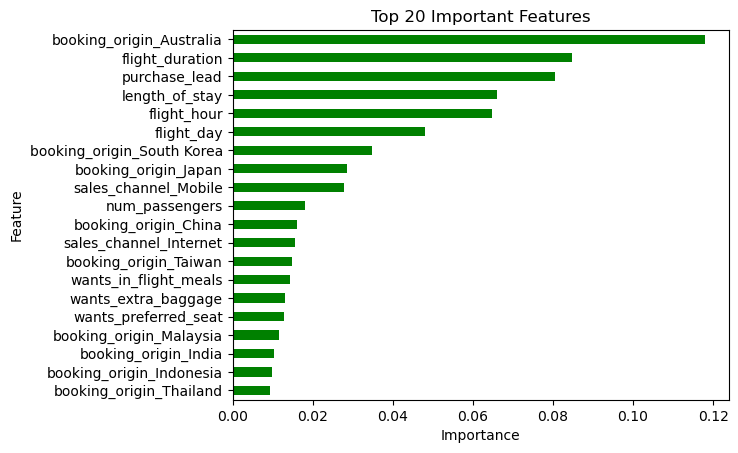

In [48]:
Top20Featurs.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")

In [35]:
def cross_validation(model,metric):
    # evaluate a model with repeated stratified k fold cv
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
    
    scores = cross_validate(model, x_sm_train, y_sm_train,
                            scoring=metric, cv=cv, n_jobs=-1,return_estimator=True)
    print("score: ",scores["test_score"].mean()*100)
    
    predictions=scores["estimator"][0].predict(x_test)
   
    matrix=confusion_matrix(predictions,y_test)
    print(matrix)
    print(classification_report(predictions,y_test))
    sns.heatmap(matrix,annot=True)
    plt.xlabel("Predictions")
    plt.ylabel("True classes ")
    plt.tilte("Classification matrix")

score:  81.30512538630185
[[6306  813]
 [1742  712]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      7119
           1       0.47      0.29      0.36      2454

    accuracy                           0.73      9573
   macro avg       0.63      0.59      0.59      9573
weighted avg       0.70      0.73      0.71      9573



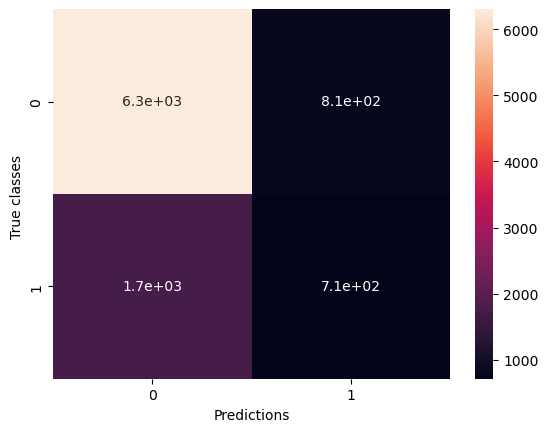

In [36]:
cross_validation(lr,"accuracy")

score:  84.97797363329495
[[6775 1025]
 [1273  500]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7800
           1       0.33      0.28      0.30      1773

    accuracy                           0.76      9573
   macro avg       0.58      0.58      0.58      9573
weighted avg       0.75      0.76      0.75      9573



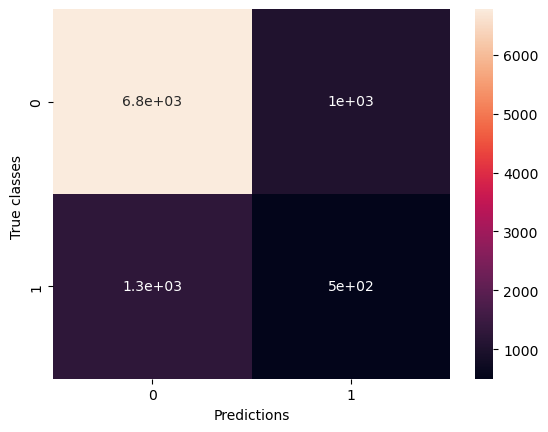

In [37]:
cross_validation(tree,"accuracy")

score:  87.20344460578136
[[7254 1086]
 [ 794  439]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8340
           1       0.29      0.36      0.32      1233

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



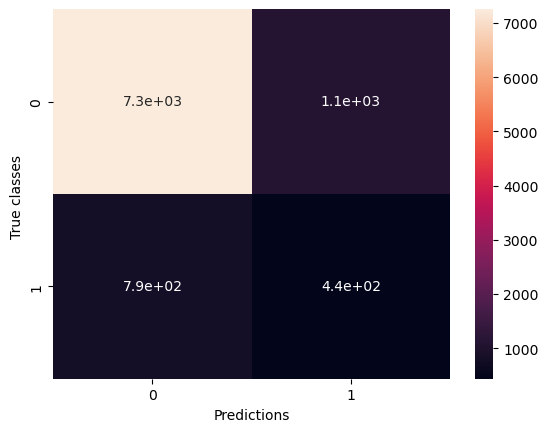

In [44]:
cross_validation(xgb,"accuracy")

score:  87.85100123377529
[[7263 1098]
 [ 785  427]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8361
           1       0.28      0.35      0.31      1212

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



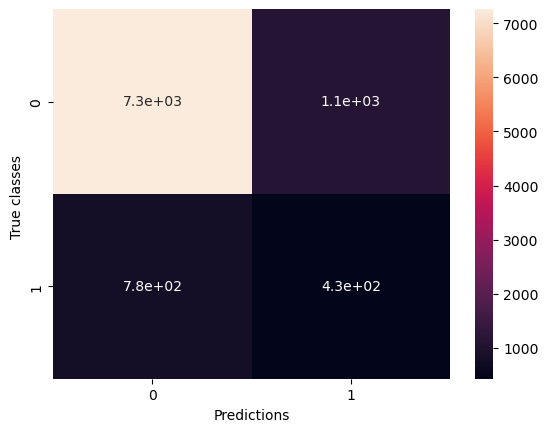

In [40]:
cross_validation(rnf,"f1")

score:  80.58411501153562
[[6306  813]
 [1742  712]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      7119
           1       0.47      0.29      0.36      2454

    accuracy                           0.73      9573
   macro avg       0.63      0.59      0.59      9573
weighted avg       0.70      0.73      0.71      9573



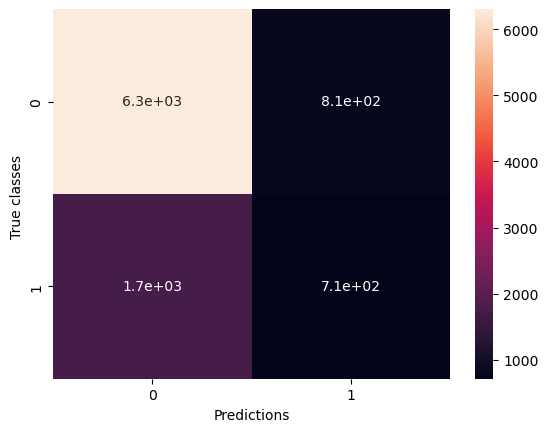

In [41]:
cross_validation(lr,"f1")

score:  84.74312770315606
[[6785 1025]
 [1263  500]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7810
           1       0.33      0.28      0.30      1763

    accuracy                           0.76      9573
   macro avg       0.59      0.58      0.58      9573
weighted avg       0.75      0.76      0.75      9573



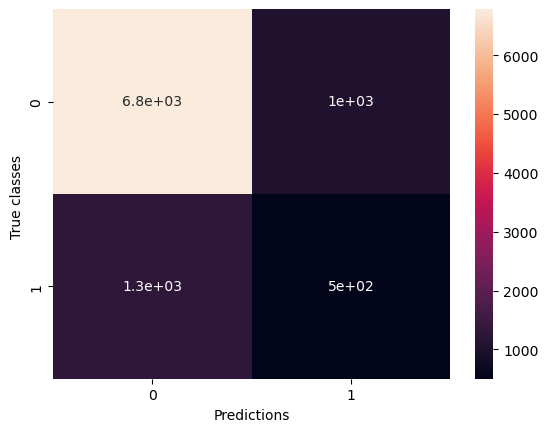

In [42]:
cross_validation(tree,"f1")

score:  86.39908985932789
[[7254 1086]
 [ 794  439]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8340
           1       0.29      0.36      0.32      1233

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



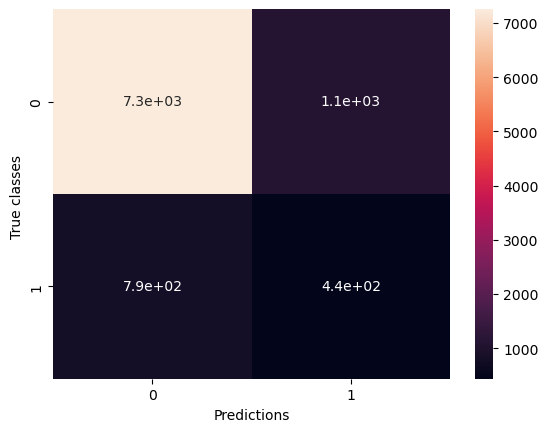

In [43]:
cross_validation(xgb,"f1")

In [39]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

score:  88.34113503923426
[[7259 1095]
 [ 789  430]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8354
           1       0.28      0.35      0.31      1219

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



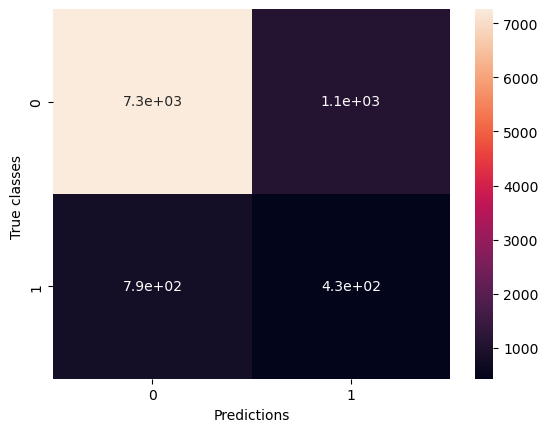

In [45]:
cross_validation(rnf,"balanced_accuracy")

score:  81.26580460172926
[[6306  813]
 [1742  712]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      7119
           1       0.47      0.29      0.36      2454

    accuracy                           0.73      9573
   macro avg       0.63      0.59      0.59      9573
weighted avg       0.70      0.73      0.71      9573



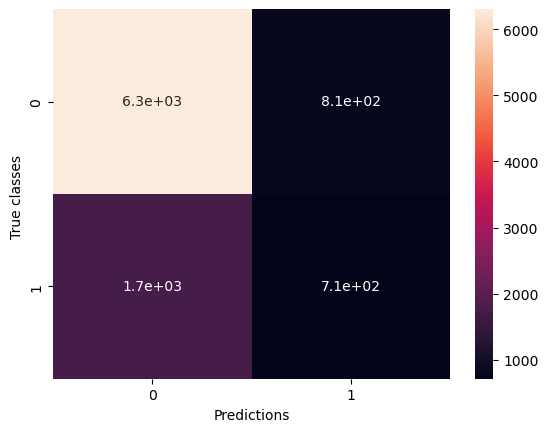

In [46]:
cross_validation(lr,"balanced_accuracy")

score:  84.9967178786026
[[6747 1018]
 [1301  507]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7765
           1       0.33      0.28      0.30      1808

    accuracy                           0.76      9573
   macro avg       0.59      0.57      0.58      9573
weighted avg       0.74      0.76      0.75      9573



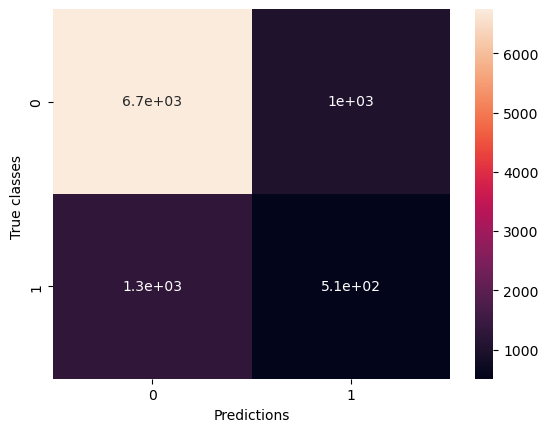

In [47]:
cross_validation(tree,"balanced_accuracy")

score:  87.10568317925666
[[7254 1086]
 [ 794  439]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8340
           1       0.29      0.36      0.32      1233

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



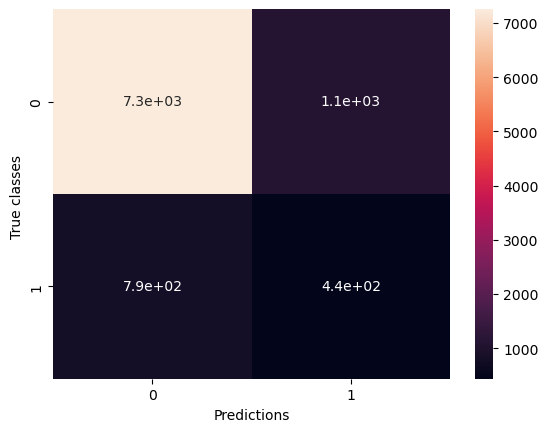

In [48]:
cross_validation(xgb,"balanced_accuracy")

score:  95.32770520459474
[[7273 1106]
 [ 775  419]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8379
           1       0.27      0.35      0.31      1194

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.83      0.80      0.81      9573



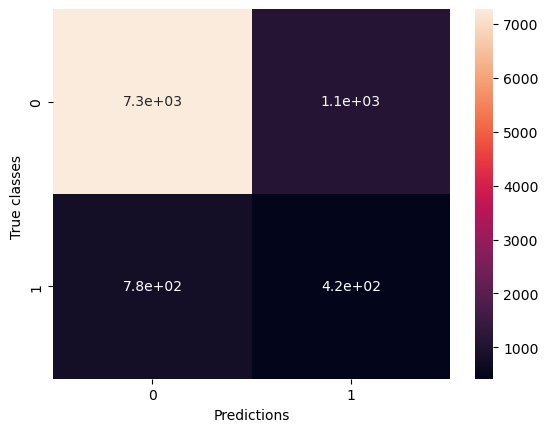

In [49]:
cross_validation(rnf,"roc_auc")

score:  94.36211840443931
[[7254 1086]
 [ 794  439]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8340
           1       0.29      0.36      0.32      1233

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



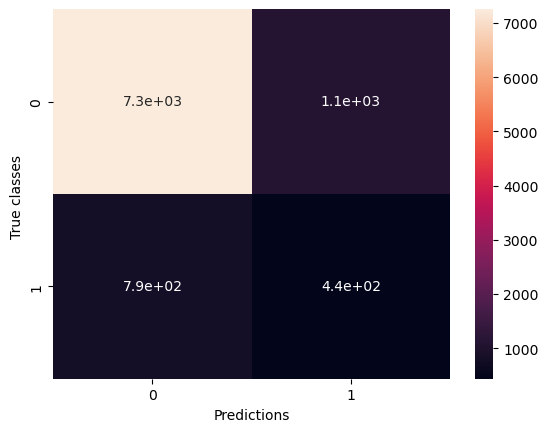

In [50]:
cross_validation(xgb,"roc_auc")

score:  89.6952621978852
[[6306  813]
 [1742  712]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      7119
           1       0.47      0.29      0.36      2454

    accuracy                           0.73      9573
   macro avg       0.63      0.59      0.59      9573
weighted avg       0.70      0.73      0.71      9573



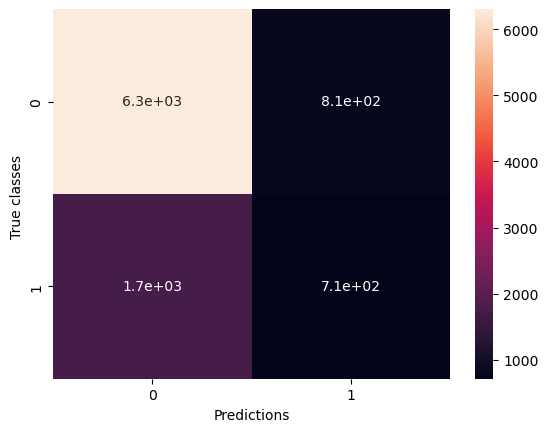

In [51]:
cross_validation(lr,"roc_auc")

score:  84.97925084321241
[[6764 1026]
 [1284  499]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7790
           1       0.33      0.28      0.30      1783

    accuracy                           0.76      9573
   macro avg       0.58      0.57      0.58      9573
weighted avg       0.74      0.76      0.75      9573



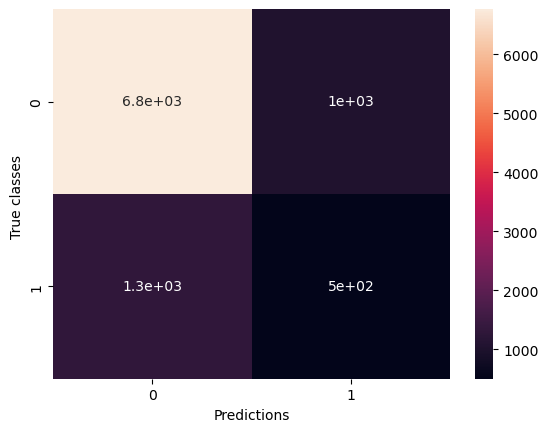

In [52]:
cross_validation(tree,"roc_auc")

score:  -27.05002441868861
[[7267 1097]
 [ 781  428]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8364
           1       0.28      0.35      0.31      1209

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



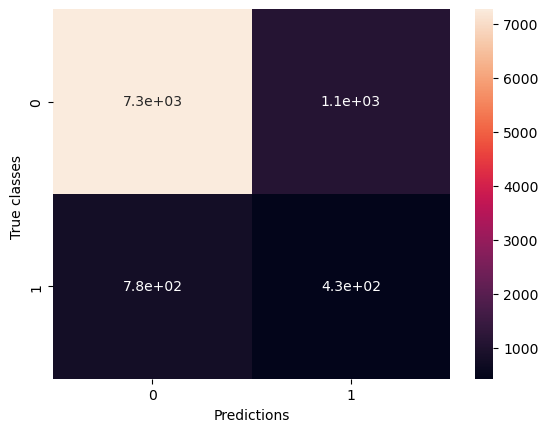

In [53]:
cross_validation(rnf,"neg_log_loss")

score:  -539.2781252625797
[[6793 1045]
 [1255  480]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7838
           1       0.31      0.28      0.29      1735

    accuracy                           0.76      9573
   macro avg       0.58      0.57      0.57      9573
weighted avg       0.75      0.76      0.75      9573



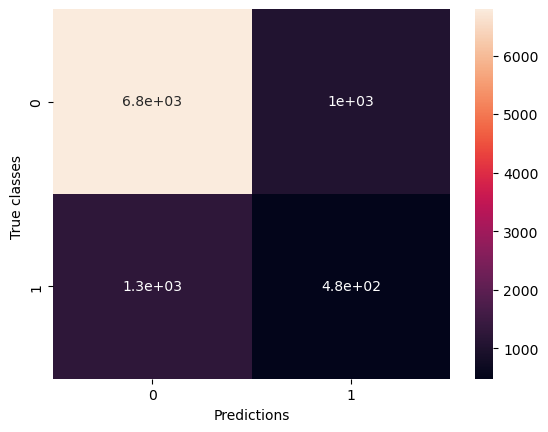

In [54]:
cross_validation(tree,"neg_log_loss")

score:  -29.553710487647862
[[7254 1086]
 [ 794  439]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      8340
           1       0.29      0.36      0.32      1233

    accuracy                           0.80      9573
   macro avg       0.59      0.61      0.60      9573
weighted avg       0.82      0.80      0.81      9573



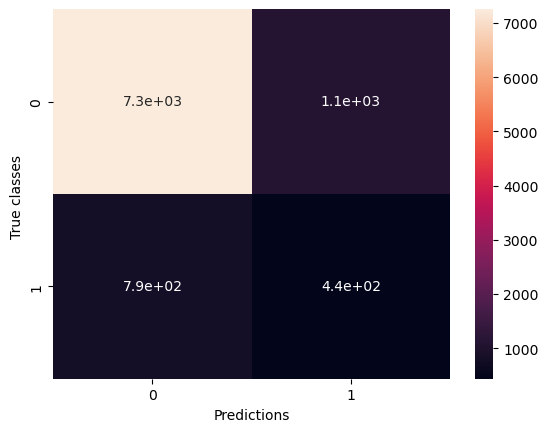

In [55]:
cross_validation(xgb,"neg_log_loss")

score:  -40.760733862084244
[[6306  813]
 [1742  712]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      7119
           1       0.47      0.29      0.36      2454

    accuracy                           0.73      9573
   macro avg       0.63      0.59      0.59      9573
weighted avg       0.70      0.73      0.71      9573



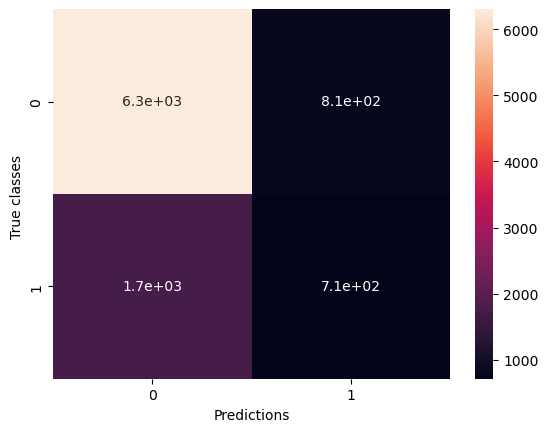

In [56]:
cross_validation(lr,"neg_log_loss")

In [183]:
def cross_val(model,metric):
    # evaluate a model with repeated stratified k fold cv
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, Y, scoring=metric, cv=cv, n_jobs=-1)
    predictions=cross_val_predict(model,X,Y,cv=5)
    print("score: ",np.mean(scores)*100)
    matrix=confusion_matrix(predictions,Y)
    print(matrix)
    print(classification_report(predictions,Y))
    sns.heatmap(matrix,annot=True)
    plt.xlabel("Predictions")
    plt.ylabel("True classes ")

83.99251454014308
[[19104  3692]
 [ 7721  1391]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77     22796
           1       0.27      0.15      0.20      9112

    accuracy                           0.64     31908
   macro avg       0.49      0.50      0.48     31908
weighted avg       0.59      0.64      0.61     31908



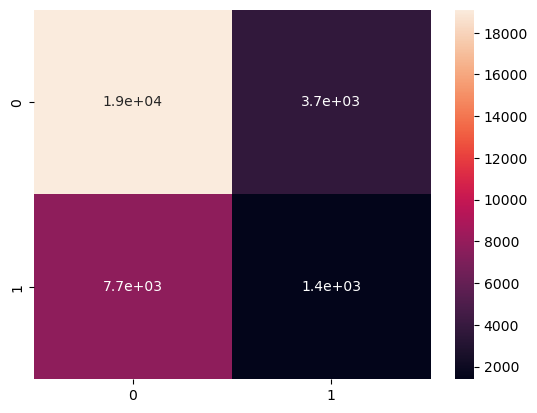

In [24]:
cross_val(xgb,"accuracy")

77.95849972509542
[[17096  3521]
 [ 9729  1562]]
              precision    recall  f1-score   support

           0       0.64      0.83      0.72     20617
           1       0.31      0.14      0.19     11291

    accuracy                           0.58     31908
   macro avg       0.47      0.48      0.46     31908
weighted avg       0.52      0.58      0.53     31908



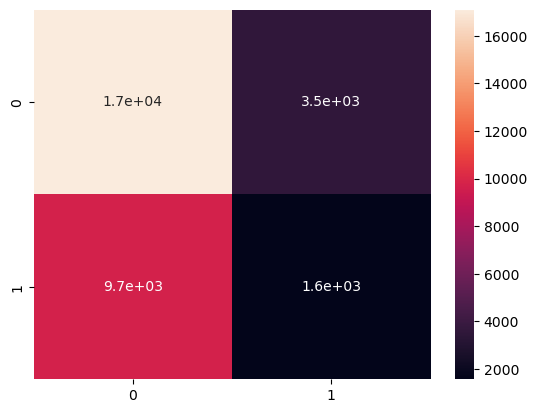

In [25]:
cross_val(tree,"accuracy")

83.7835756062882
[[22282  4407]
 [ 4543   676]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     26689
           1       0.13      0.13      0.13      5219

    accuracy                           0.72     31908
   macro avg       0.48      0.48      0.48     31908
weighted avg       0.72      0.72      0.72     31908



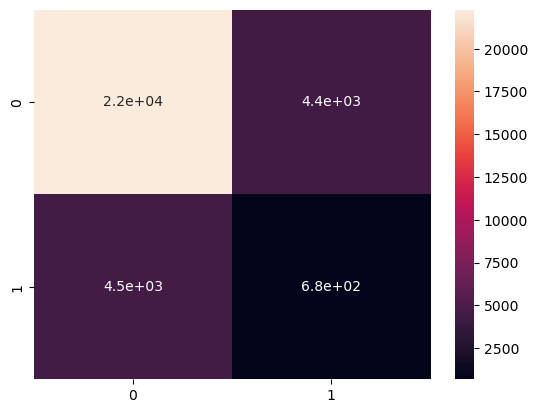

In [26]:
cross_val(rnf,"accuracy")

C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

84.09489987350133
[[26244  4860]
 [  581   223]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     31104
           1       0.04      0.28      0.08       804

    accuracy                           0.83     31908
   macro avg       0.51      0.56      0.49     31908
weighted avg       0.95      0.83      0.89     31908



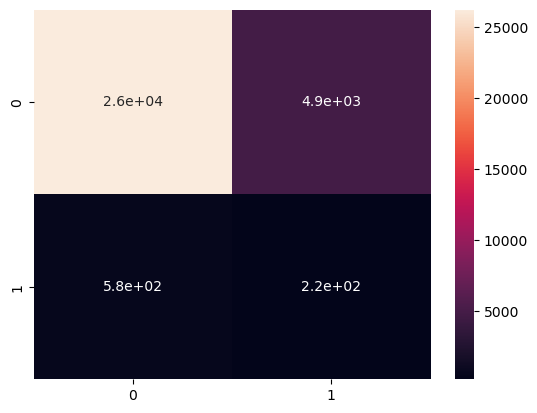

In [27]:
cross_val(lr,"accuracy")

## we can see the best models are Logitic Regression and Random Forest.

In [30]:
#let's try to evalaute those models using other metrics F2_score and G_mean 

<module 'sklearn.metrics' from 'C:\\Users\\hp\\anaconda3_2023\\Lib\\site-packages\\sklearn\\metrics\\__init__.py'>


In [19]:
beta=2
f2_scorer = make_scorer(fbeta_score, beta=beta)
g_mean_scorer = make_scorer(geometric_mean_score)

14.84004874342201
[[22290  4407]
 [ 4535   676]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     26697
           1       0.13      0.13      0.13      5211

    accuracy                           0.72     31908
   macro avg       0.48      0.48      0.48     31908
weighted avg       0.72      0.72      0.72     31908



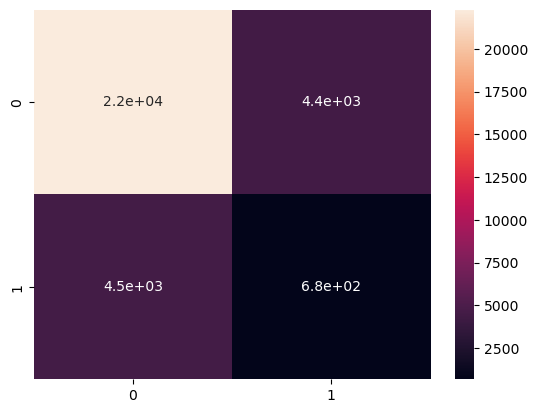

In [38]:
cross_val(rnf,f2_scorer)

C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

score:  4.1674771942887965
[[26244  4860]
 [  581   223]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     31104
           1       0.04      0.28      0.08       804

    accuracy                           0.83     31908
   macro avg       0.51      0.56      0.49     31908
weighted avg       0.95      0.83      0.89     31908



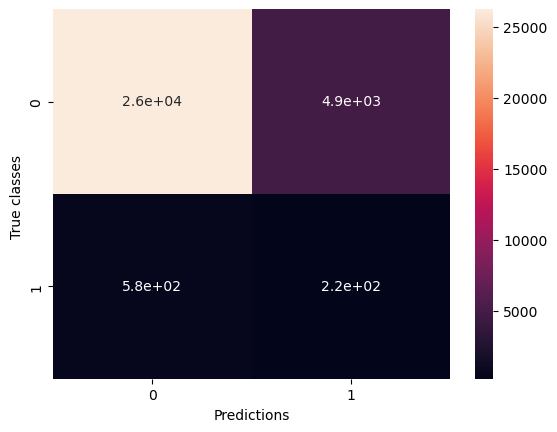

In [45]:
cross_val(lr,f2_scorer)

score:  35.20172201406798
[[22354  4392]
 [ 4471   691]]
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     26746
           1       0.14      0.13      0.13      5162

    accuracy                           0.72     31908
   macro avg       0.48      0.48      0.48     31908
weighted avg       0.72      0.72      0.72     31908



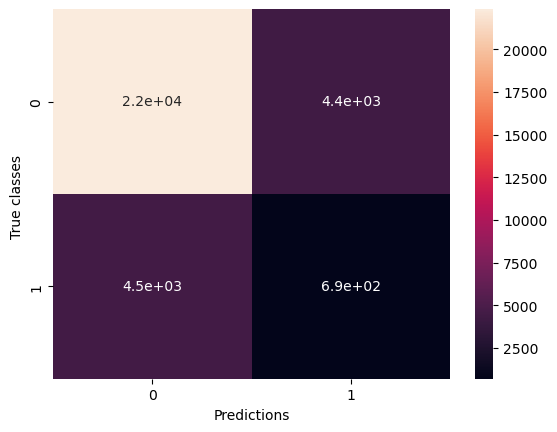

In [21]:
cross_val(rnf,g_mean_scorer)

C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

score:  17.65538770627401
[[26244  4860]
 [  581   223]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     31104
           1       0.04      0.28      0.08       804

    accuracy                           0.83     31908
   macro avg       0.51      0.56      0.49     31908
weighted avg       0.95      0.83      0.89     31908



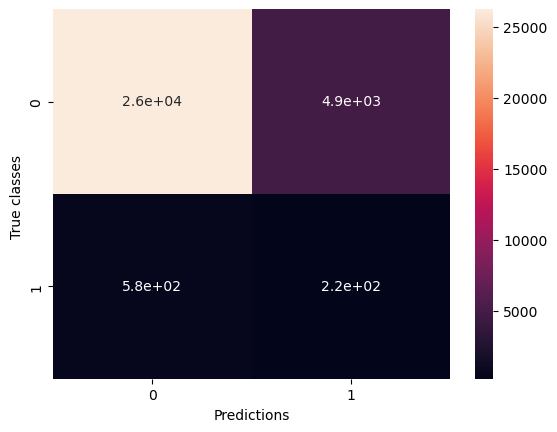

In [22]:
cross_val(lr,g_mean_scorer)

score:  50.95933105256803
[[17123  3502]
 [ 9702  1581]]
              precision    recall  f1-score   support

           0       0.64      0.83      0.72     20625
           1       0.31      0.14      0.19     11283

    accuracy                           0.59     31908
   macro avg       0.47      0.49      0.46     31908
weighted avg       0.52      0.59      0.53     31908



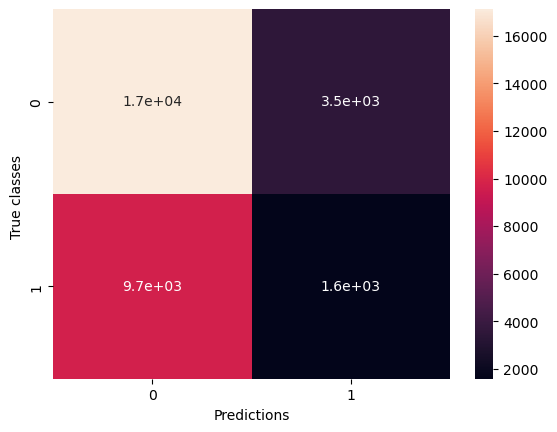

In [23]:
cross_val(tree,g_mean_scorer)

score:  32.47054028795737
[[19104  3692]
 [ 7721  1391]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77     22796
           1       0.27      0.15      0.20      9112

    accuracy                           0.64     31908
   macro avg       0.49      0.50      0.48     31908
weighted avg       0.59      0.64      0.61     31908



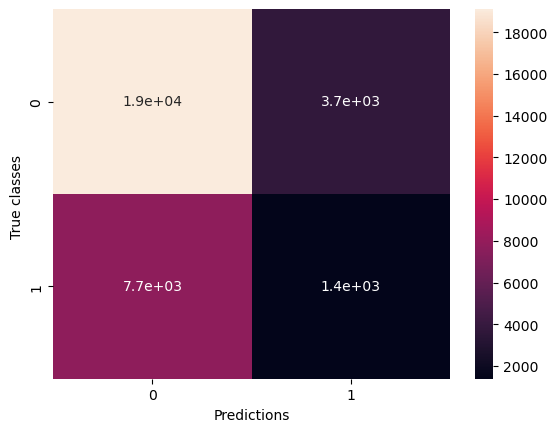

In [24]:
cross_val(xgb,g_mean_scorer)

# Hyper-tunning Models (tree and rnf).

In [29]:
params={"n_estimators":[int(x) for x in np.linspace(start=10,stop=80,num=10)],
    "criterion":['gini'],
    "max_depth":[2,3,4,5],
    "min_samples_split":[2,3,4,5],
   "min_samples_leaf":[1,2],
    "max_features":['auto','sqrt']
                                                    }
gs_rnf=GridSearchCV(estimator=rnf, param_grid=params,cv=10,verbose=4,n_jobs=2)
gs_rnf.fit(x_train,y_train)               

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini'], 'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=4)

In [30]:
gs_rnf.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [ ]:
{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [33]:
rnf_best_params=RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None)

C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hp\anaconda3_2023\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

score:  0.0
[[26825  5083]
 [    0     0]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     31908
           1       0.00      0.00      0.00         0

    accuracy                           0.84     31908
   macro avg       0.50      0.42      0.46     31908
weighted avg       1.00      0.84      0.91     31908



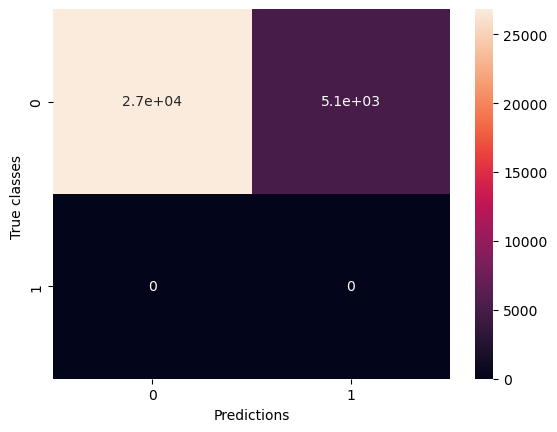